<h2><center>Image Classification with TensorFlow</center></h2>

Importing some required libraries and setting some configurations

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
#Define the data folder path
cifar10_dataset_folder_path = "cifar-10-python\\cifar-10-batches-py"

<h3>Helper Functions</h3>
- <b>unpickle</b> read a pickle data file into a dictionary. Reads and loads the label names.
- <b>load_cfar10_batch</b> Loads the training data splits and reshapes them to remove the inherent transpose in the data. Returns the features and labels extracted
- <b>_load_label_names</b> Loads the metadata file describing the categories of data present.

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='bytes')
    return dict_data

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    return features, labels

def _load_label_names():
    labels = unpickle("cifar-10-python/cifar-10-batches-py/batches.meta")[b'label_names']
    names = [x.decode('utf-8') for x in labels]
    print("Categories : ", names)
    return names


<h3>Pre Processinig</h3>

<h4>Helper Functions</h4>
- <b>normalize</b> The data might not be normalized so created a function to normalize the input features
- <b>one_hot_encode</b> Y labels are given as integer values but in order to make the classification I used one hot encoding to convert these y values into a shape( length, numb classes)
- <b>_preprocess</b> Function to do the above two preprocesses

In [4]:
"""normalize the values in input data"""
def normalize(x):
    maximum = np.max(x)
    minimum = np.min(x)
    return (x - minimum) / (maximum - minimum)

"""convert y values into 0 and 1s"""
def one_hot_encode(x):
    nx = np.max(x) + 1
    return np.eye(nx)[x]

"""save the preprocessed file into a file."""
def _preprocess(normalize, one_hot_encode, features, labels):
    features = normalize(features)
    labels = one_hot_encode(labels)
    return features, labels

"""preprocess both train and test datasets."""
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []
    train_features_arry = np.zeros((5, 9000, 32, 32, 3))
    train_labels_arry = np.zeros((5, 9000, 10))
    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        train_features, train_labels = _preprocess(
                                        normalize,
                                        one_hot_encode,
                                        features[:-validation_count],
                                        labels[:-validation_count])
        print("train_features, train_labels :", train_features.shape, train_labels.shape)

        train_features_arry[batch_i - 1] = train_features
        train_labels_arry[batch_i - 1] = train_labels
        
        
        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    valid_features, valid_labels = _preprocess(
                                                normalize,
                                                one_hot_encode,
                                                np.array(valid_features),
                                                np.array(valid_labels))

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    test_features, test_labels =  _preprocess(
                                                normalize,
                                                one_hot_encode,
                                                np.array(test_features),
                                                np.array(test_labels))
    return train_features_arry, train_labels_arry, valid_features, valid_labels, test_features,test_labels

In [5]:
train_features_arry, train_labels_arry, valid_features, valid_labels, test_features,test_labels = preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

train_features, train_labels : (9000, 32, 32, 3) (9000, 10)
train_features, train_labels : (9000, 32, 32, 3) (9000, 10)
train_features, train_labels : (9000, 32, 32, 3) (9000, 10)
train_features, train_labels : (9000, 32, 32, 3) (9000, 10)
train_features, train_labels : (9000, 32, 32, 3) (9000, 10)


In [6]:
print("Shape of x data for a single batch :", train_features_arry[0].shape)

Shape of x data for a single batch : (9000, 32, 32, 3)


In [7]:
train_labels_arry[0].shape

(9000, 10)

In [8]:
names = _load_label_names()
print(names)

Categories :  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
your_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dict_names = {key: i for key, i in enumerate(your_list)}
print(dict_names)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [10]:
IMAGE_SIZE = 32

<h3>Plotting a sample input data</h3>

(9000, 32, 32, 3)


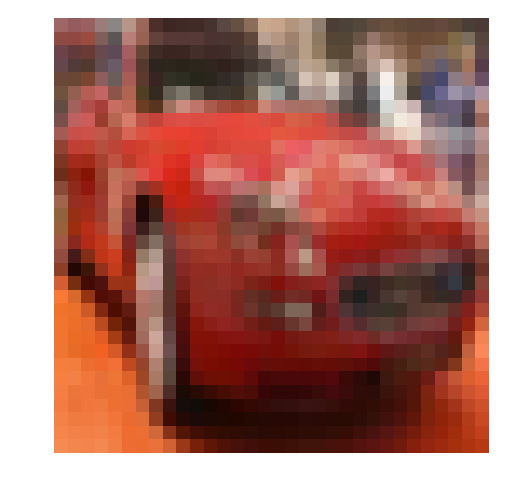

In [11]:
plt.axis('off')
batch1 = train_features_arry[0]
print(batch1.shape)
plt.imshow(batch1[5])
plt.show()

<h3>Build the model</h3>

<h4>Helper Functions</h4>
- <b>conv2d_maxpool</b> A function that helps in creating a convolution layer followed by a max pool layer.
- <b>flatten</b> Flattens the output of the previous layer.
- <b>fully_conn</b> A function to help creating of fully connected layers.
- <b>output</b> A function to create the output layer to be softmaxed.

In [12]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize,
                   conv_strides, pool_ksize, pool_strides):

    input_depth = x_tensor.get_shape().as_list()[-1]
    W = tf.Variable(tf.random_normal(
        [conv_ksize[0], conv_ksize[1], input_depth, conv_num_outputs],
        stddev=0.1
    ))
    tf.summary.histogram("W", W)
    b = tf.Variable(tf.zeros(conv_num_outputs))
    conv = tf.nn.conv2d(x_tensor, W, [1, conv_strides[0], conv_strides[1], 1], 'SAME') + b
    conv = tf.nn.relu(conv)
    return tf.nn.max_pool(
        conv,
        [1, pool_ksize[0], pool_ksize[1], 1],
        [1, pool_strides[0], pool_strides[1], 1],
        'SAME'
    )

def flatten(x_tensor):
    shape = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor, [-1, np.prod(shape[1:])])

def fully_conn(x_tensor, num_outputs):
    shape = x_tensor.get_shape().as_list()
    W = tf.Variable(tf.random_normal([shape[-1], num_outputs], stddev=0.1))
    b = tf.Variable(tf.zeros(num_outputs)) + 0.11
    return tf.nn.relu(tf.add(tf.matmul(x_tensor, W), b))

def output(x_tensor, num_outputs):
    shape = x_tensor.get_shape().as_list()
    W = tf.Variable(tf.random_normal([shape[-1], num_outputs]))
    b = tf.Variable(tf.zeros(num_outputs))
    return tf.add(tf.matmul(x_tensor, W), b)

<h4>Helper Functions</h4>
- <b>central_scale_images</b> A function to scale images based on the scaling factors mentioned using tensorflow.
    - <b>tf.image.crop_and_resize</b> - Extracts crops from the input image tensor and bilinearly resizes them (possibly with aspect ratio change) to a common output size specified by crop_size
- <b>rotate_images</b> Function that rotates the given images into 90, 180 degrees
    - <b>tf.image.rot90</b> - Rotate image(s) counter-clockwise by 90 degrees

In [13]:
def central_scale_images(X_imgs, scales):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data


def rotate_images(X_imgs):
    X_rotate = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            for i in range(2):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
                X_rotate.append(rotated_img)
        
    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate


<h3>Data Augmentation</h3>
- <b>Different Scale</b>

In [14]:
scaled_imgs = central_scale_images(batch1[:5], [0.90, 0.60])
print(scaled_imgs.shape)
batch1_label = train_labels_arry[0]
labels = [val for val in batch1_label[:5] for _ in (0, 1)]
labels =  np.array(labels, dtype = np.float32)
labels.shape

(10, 32, 32, 3)


(10, 10)

label : truck


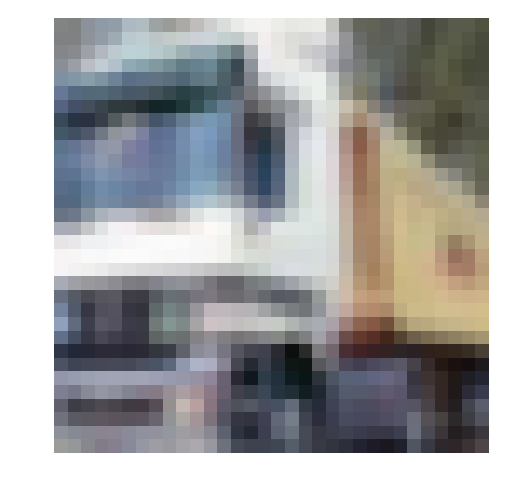

label : truck


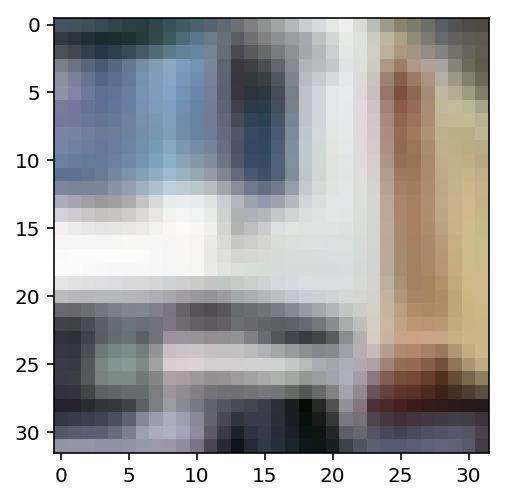

In [15]:
plt.axis('off')
plt.imshow(scaled_imgs[2])
print("label :", dict_names[np.argmax(labels[2])])
plt.show()
plt.imshow(scaled_imgs[3])
print("label :", dict_names[np.argmax(labels[3])])
plt.show()

- <b>Rotated images</b>

In [16]:
rotated_imgs = rotate_images(batch1[0:5])

(10, 32, 32, 3)


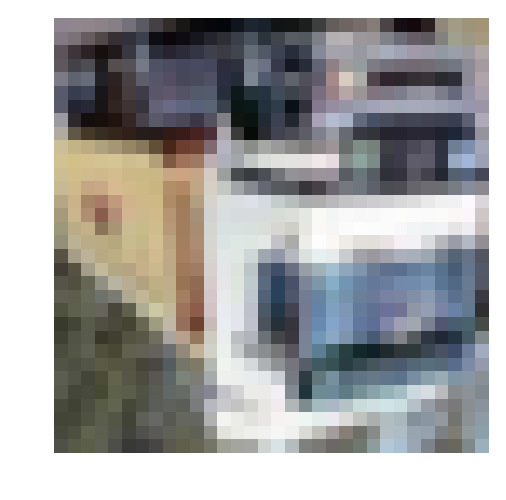

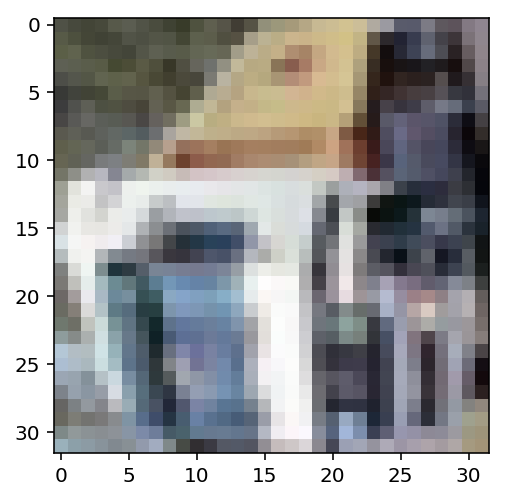

In [17]:
print(rotated_imgs.shape)
plt.axis('off')
plt.imshow(rotated_imgs[3])
plt.show()
plt.imshow(rotated_imgs[2])
plt.show()

In [18]:
"""Define Parameters"""
image_shape = [32, 32, 3]
n_classes = 10
epochs = 20
batch_size = 1000
keep_probability = 0.5
logs_path = 'C:\\Users\\Kiran\\Desktop\\S2\\DDL_Lab\\week6-CNN\\temp'

<h3>Creating the augmented data</h3>

In [19]:
#train_features_arry, train_labels_arry
aug_train_features_arry = np.zeros((5, 36000, 32, 32, 3))
aug_train_labels_arry = np.zeros((5, 36000, 10))

for i in range(5):
    """scale the images"""
    scaled_imgs = central_scale_images(train_features_arry[i], [0.60])
    
    """rotate the images"""
    rotated_imgs = rotate_images(train_features_arry[i])
    labels2 = [val for val in train_labels_arry[i] for _ in (0, 1)]
    labels2 =  np.array(labels2, dtype = np.float32)
    
    """keep the actual data"""
    actual_data = train_features_arry[i]
    actual_label = train_labels_arry[i]
    
    """stack all of these as the new augmented input features"""
    aug_train_features_arry[i] = np.vstack([actual_data, scaled_imgs, rotated_imgs])
    aug_train_labels_arry[i] = np.vstack([actual_label, actual_label, labels2])


actual_label.shape : (9000, 10)
actual_label.shape : (9000, 10)
actual_label.shape : (9000, 10)
actual_label.shape : (9000, 10)
actual_label.shape : (9000, 10)


In [20]:
aug_train_features_arry.shape

(5, 36000, 32, 32, 3)

<h3>Creating the graph</h3>

<h4>Notes</h4>
- define a placeholder for both x and y. The number of instances in the placeholder is kept as None because this changes with the batch size. Rest of the shape is the same as the image configuration.
- Data augmentation is a really good method of regularization so we can ignore using dropout along with it.
- Next we create a convolution layer with 3 x 3 kernel size and a stride of 1 x 1.
- Max pooling was applied on the output of convolution layer with a kernel size of 3 x 3 and stride of 2 x 2
- The output of the layer was flattened and then 2 Fully connected layers were applied such that the finale fully connected layer provides a output of 10 (number of labels).
- Once the output layer was defined the error was calculated using a softmax on top of the output layer and finding out the misclassification.
- The cost function used was cross entropy function 
- Optimized used was AdamOptimizer
- tensorboard summary was also created

In [21]:
tf.reset_default_graph()

"""Define x, y"""
x = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], 3], name='x')
y = tf.placeholder(tf.float32,[None, n_classes], name='y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

"""Define the model as conv1: convolution and
rectifed linear activation (RELU) and pool1: max pooling"""
tmp = conv2d_maxpool(x, 64, [3, 3], [1, 1], [2, 2], [1, 1])
tmp = flatten(tmp)

"""FC2: fully connected layer with rectifed linear activation (RELU)"""
tmp = fully_conn(tmp, 384)
tmp = fully_conn(tmp, 192)

logits = output(tmp, 10)

"""Name logits Tensor, so that is can be loaded from disk after training"""
logits = tf.identity(logits, name='logits')

"""Loss and Optimizer"""
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
tf.summary.scalar("loss", cost)

"""Accuracy"""
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
tf.summary.scalar("accuracy", accuracy)

merged_summary_op = tf.summary.merge_all()

<h4>Helper Functions</h4>
- <b>batch_features_labels</b> Gets a chunk of data based on the batch size defined
- <b>load_preprocess_training_batch</b> selects the batch to be split and passes to batch_features_labels

In [22]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
    yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):

    features = aug_train_features_arry[batch_id - 1]
    labels = aug_train_labels_arry[batch_id - 1]

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


<h3>Training</h3>

In [23]:
save_model_path = './image_classification'
acc_list = []
train_acc_list = []
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    # Training cycle
    for epoch in range(epochs):
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                _, summary, train_acc = sess.run([optimizer, merged_summary_op, accuracy],
                                              feed_dict={x: batch_features, y: batch_labels,
                                      keep_prob: keep_probability})
                
                summary_writer.add_summary(summary, epoch)
        acc = sess.run(accuracy, feed_dict={ x: valid_features,
                                            y: valid_labels,
                                            keep_prob: 1.0,})
    
        acc_list.append(acc)
        train_acc_list.append(train_acc)

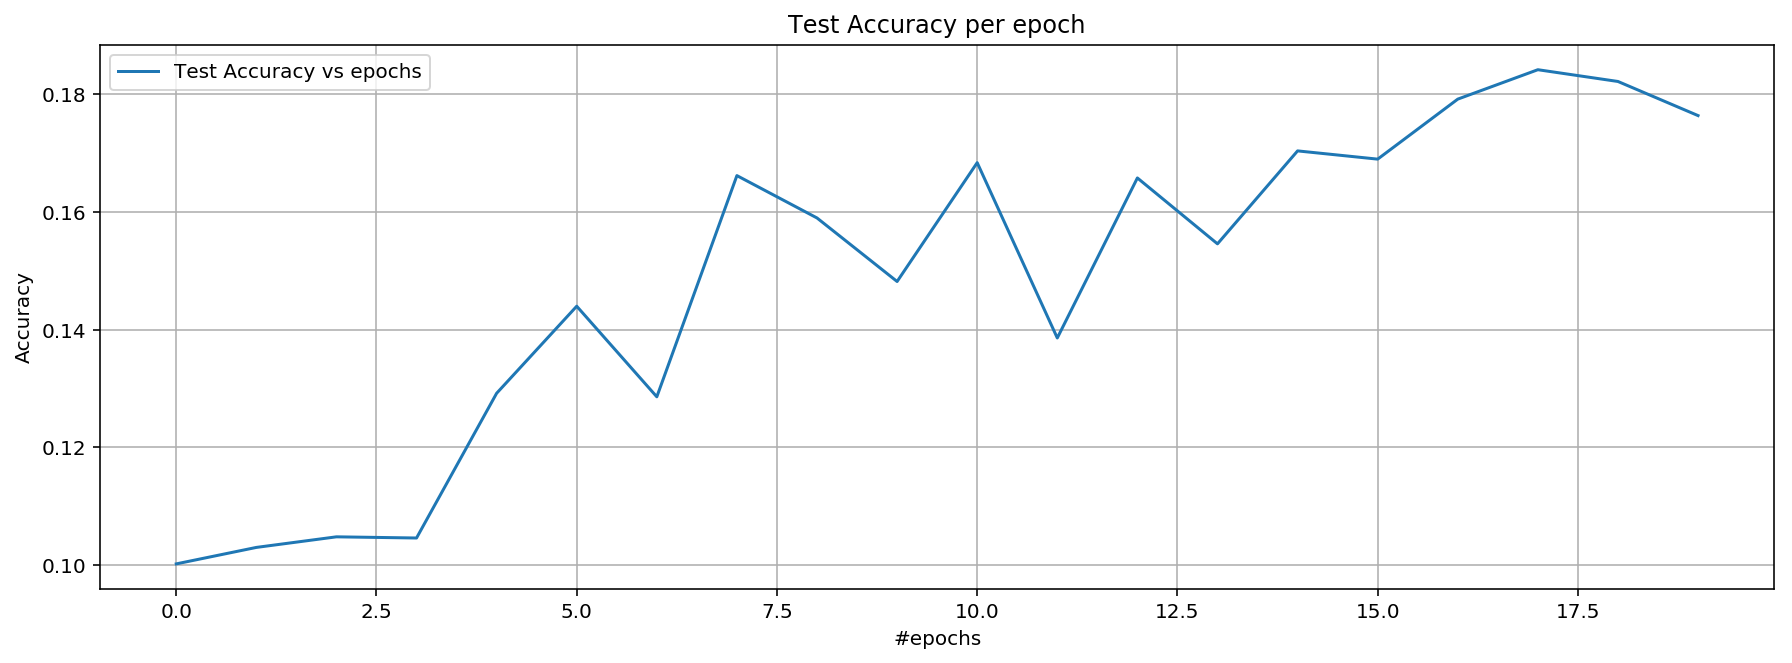

In [24]:
plt.figure(figsize = (15, 5))
plt.plot(range(epochs), acc_list, label = "Test Accuracy vs epochs")
plt.title("Test Accuracy per epoch")
plt.legend()
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

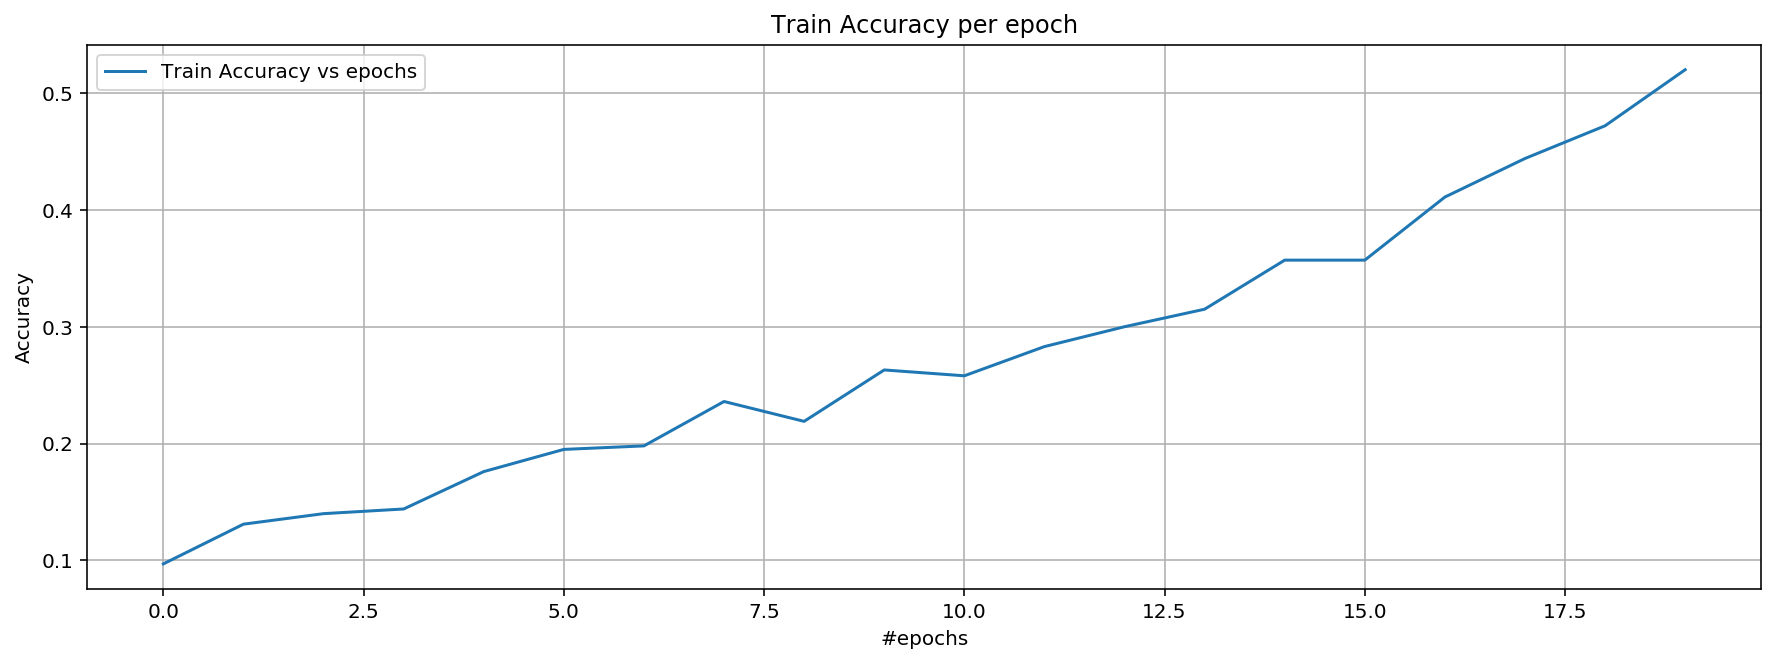

In [25]:
plt.figure(figsize = (15, 5))
plt.plot(range(epochs), train_acc_list, label = "Train Accuracy vs epochs")
plt.title("Train Accuracy per epoch")
plt.legend()
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

<h2>Working on the same data with different CNN architecture</h2>

In [26]:

"""
conv_ksize - kernel size as a list
conv_strides - convolution stride of 1 x 1

"""
def conv2d(x_tensor, conv_num_outputs, conv_ksize,
                   conv_strides):

    input_depth = x_tensor.get_shape().as_list()[-1]
    
    """initilaize weights with the kernel size"""
    
    W = tf.Variable(tf.random_normal(
        [conv_ksize[0], conv_ksize[1], input_depth, conv_num_outputs],
        stddev=0.1
    ))
    tf.summary.histogram("W", W)
    
    """intialize bias"""
    b = tf.Variable(tf.zeros(conv_num_outputs))
    
    """tf.nn.conv2d(input, filter, strides, padding)"""
    conv = tf.nn.conv2d(x_tensor, W, [1, conv_strides[0], conv_strides[1], 1], 'SAME') + b
    
    """activation using relu"""
    conv = tf.nn.selu(conv)
    
    return conv

def max_pool(conv, pool_ksize, pool_strides):
    return tf.nn.max_pool(
        conv,
        [1, pool_ksize[0], pool_ksize[1], 1],
        [1, pool_strides[0], pool_strides[1], 1],
        'SAME'
    )

def flatten(x_tensor):
    shape = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor, [-1, np.prod(shape[1:])])

def fully_conn_2(x_tensor, num_outputs):
    shape = x_tensor.get_shape().as_list()
    W = tf.Variable(tf.random_normal([shape[-1], num_outputs], stddev=0.1))
    b = tf.Variable(tf.zeros(num_outputs)) + 0.11
    return tf.nn.selu(tf.add(tf.matmul(x_tensor, W), b))

def output(x_tensor, num_outputs):
    shape = x_tensor.get_shape().as_list()
    W = tf.Variable(tf.random_normal([shape[-1], num_outputs]))
    b = tf.Variable(tf.zeros(num_outputs))
    return tf.add(tf.matmul(x_tensor, W), b)

<h4>Notes</h4>
- Model is almost similar to the previous model, except that we redefined the conv function to do just the convolution and another function to do max pool. Also substituted the relu with selu activation function.
- Created a convolution layer with 3 x 3 kernel size and a stride of 1 x 1.
- Max pooling was applied on the output of convolution layer with a kernel size of 3 x 3 and stride of 2 x 2
- Batch normalization was applied to the output of the max pool layer.
- The output of the layer was flattened and then 2 Fully connected layers were applied such that the finale fully connected layer provides a output of 10 (number of labels).
- Once the output layer was defined the error was calculated using a softmax on top of the output layer and finding out the misclassification.
- The cost function used was cross entropy function 
- Optimized used was AdamOptimizer
- tensorboard summary was also created

<h3>Why Batch Norm Works</h3>

- Normalizing the input in the neural network, we don't have to worry about the scale of input features. Thus, the gradient descent can reduce the oscillations when approaching the minimum point and converge faster.

- Another important fact is that Batch Norm reduces the impacts of earlier layers on the later layers in deep neural network. If we take a slice from the middle of our neural network, suppose layer 5, we can find the input features of layer 5 change during the training. Therefore, it takes more time to train the model to converge.

- However, the use of Batch Norm can reduce the impacts of earlier layers by keeping the mean and variance fixed, which in some way makes the layers independent with each other. Consequently, the convergences become must faster

In [27]:
tf.reset_default_graph()
"""Define x, y and dropout percent"""
x = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], 3], name='x')
y = tf.placeholder(tf.float32,[None, n_classes], name='y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

epsilon = 1e-3

"""create the model"""
#1 conv layer
tmp = conv2d(x, 64, [3, 3], [1, 1])
#1 pooling layer
tmp = max_pool(tmp, [3, 3], [2, 2])

#batch normalization
batch_mean, batch_var = tf.nn.moments(tmp,[0])
scale = tf.Variable(tf.ones([64]))
beta = tf.Variable(tf.zeros([64]))
tmp = tf.nn.batch_normalization(tmp, batch_mean, batch_var, beta, scale, epsilon)

#another pooling layer
tmp = max_pool(tmp, [3, 3], [2, 2])

#2 fully connected layers
tmp = flatten(tmp)
tmp = fully_conn(tmp, 384)
# tf.nn.dropout(tmp, keep_prob=keep_prob)
tmp = fully_conn(tmp, 192)
# tf.nn.dropout(tmp, keep_prob=keep_prob)
logits = output(tmp, 10)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
tf.summary.scalar("loss", cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tf.summary.scalar("accuracy", accuracy)
merged_summary_op = tf.summary.merge_all()

In [28]:
"""parameters"""
epochs = 20
batch_size = 1000
keep_probability = 0.5
logs_path = 'C:\\Users\\Kiran\\Desktop\\S2\\DDL_Lab\\week6-CNN\\temp2'

In [29]:
save_model_path = './image_classification2'
acc_list = []
train_acc_list = []
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    # Training cycle
    for epoch in range(epochs):
        avg_avg_train_acc = 0
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            avg_train_acc = 0
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                _, summary, train_acc = sess.run([optimizer, merged_summary_op, accuracy],
                                              feed_dict={x: batch_features, y: batch_labels,
                                      keep_prob: keep_probability})
                summary_writer.add_summary(summary, epoch)
#             print("avg_train_acc :", avg_train_acc)
#         print("avg_avg_train_acc", avg_avg_train_acc)
                           
        acc = sess.run(accuracy, feed_dict={ x: valid_features,
                                            y: valid_labels,
                                            keep_prob: 1.0,})
    
        acc_list.append(acc)
        train_acc_list.append(train_acc)

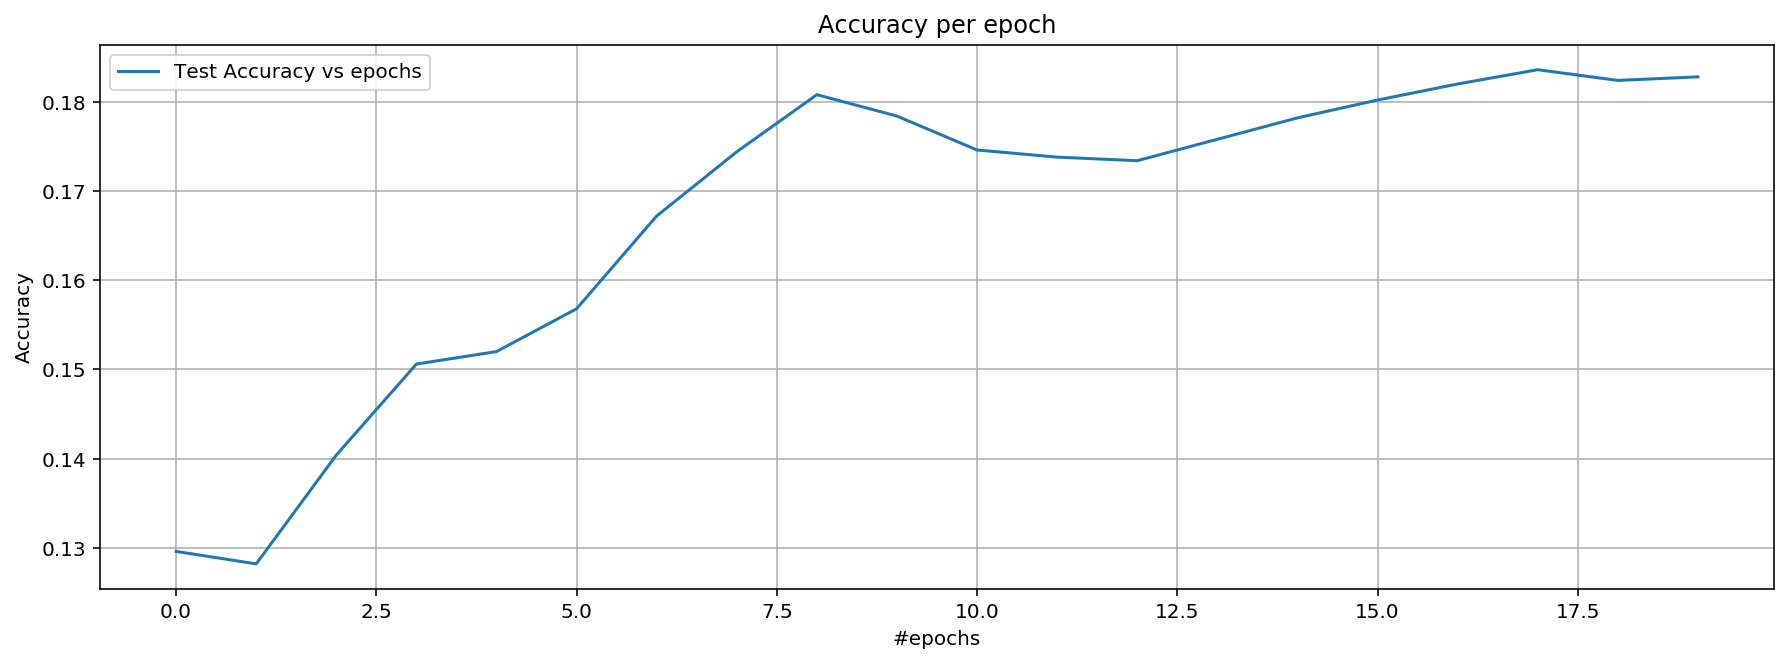

In [30]:
plt.figure(figsize = (15, 5))
plt.plot(range(epochs), acc_list, label = "Test Accuracy vs epochs")
plt.title("Accuracy per epoch")
plt.legend()
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

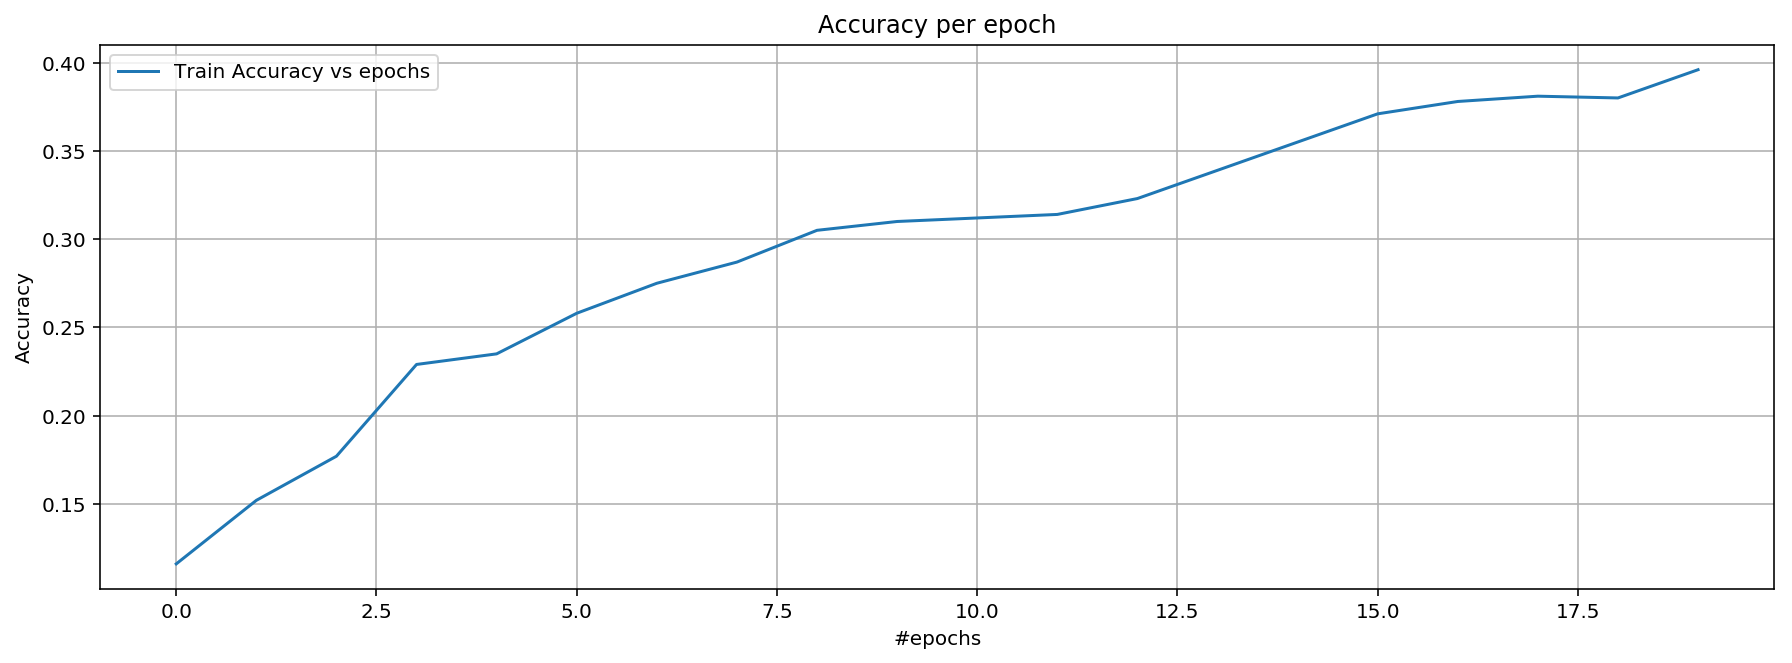

In [31]:

plt.figure(figsize = (15, 5))
plt.plot(range(epochs), train_acc_list, label = "Train Accuracy vs epochs")
plt.title("Accuracy per epoch")
plt.legend()
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()